In [1]:
import random
import math
import json

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import multiprocessing as mp
import pandas as pd
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
!pip install -q gdown

In [5]:
import gdown

def download_model(file_id):
    url = f"https://drive.google.com/uc?id={file_id}"
    output_path = "/kaggle/working/best_model.pt"  # or whatever name you want
    gdown.download(url, output_path, quiet=False)

model_id = "1lD-vSKBITv8zb8D_l7eA16GsyaFBOgcY" 
download_model(model_id)

Downloading...
From (original): https://drive.google.com/uc?id=1lD-vSKBITv8zb8D_l7eA16GsyaFBOgcY
From (redirected): https://drive.google.com/uc?id=1lD-vSKBITv8zb8D_l7eA16GsyaFBOgcY&confirm=t&uuid=2bb08933-c393-46d7-b4f9-168295c2534a
To: /kaggle/working/best_model.pt
100%|██████████| 88.8M/88.8M [00:01<00:00, 50.0MB/s]


In [6]:
def download_data(file_id, type_='train'):
    url = f"https://drive.google.com/uc?id={file_id}"
    output_path = f"/kaggle/working/{type_}_data.json"  # or whatever name you want
    gdown.download(url, output_path, quiet=False)
    
train_id = '1RqXrXa3HqjBK0lpdyWY1oXTtxaLvphqv'
val_id = '1XUtmAElweSaxAuqnnEy4sKbiblyzhx9m'
test_id = '16NnoOv1AGqQF5J_lQuRJCrcrwEsOXuI-'
unseen_id = '1xPiMjlRay5ZUAa1yFUHP27zsTiZlxtp0'
download_data(train_id, type_ = 'train')
download_data(val_id, type_ = 'val')
download_data(test_id, type_ = 'test')
download_data(unseen_id, type_ = 'unseen')

Downloading...
From: https://drive.google.com/uc?id=1RqXrXa3HqjBK0lpdyWY1oXTtxaLvphqv
To: /kaggle/working/train_data.json
100%|██████████| 3.23M/3.23M [00:00<00:00, 104MB/s]
Downloading...
From: https://drive.google.com/uc?id=1XUtmAElweSaxAuqnnEy4sKbiblyzhx9m
To: /kaggle/working/val_data.json
100%|██████████| 404k/404k [00:00<00:00, 101MB/s]
Downloading...
From: https://drive.google.com/uc?id=16NnoOv1AGqQF5J_lQuRJCrcrwEsOXuI-
To: /kaggle/working/test_data.json
100%|██████████| 404k/404k [00:00<00:00, 101MB/s]
Downloading...
From: https://drive.google.com/uc?id=1xPiMjlRay5ZUAa1yFUHP27zsTiZlxtp0
To: /kaggle/working/unseen_data.json
100%|██████████| 23.2k/23.2k [00:00<00:00, 29.7MB/s]


## 1. Data Preparation

In [7]:
def get_min_limit(min_digits):
    return 0 if min_digits==1 else 10**(min_digits-1)

In [8]:
def generate_problem(min_digits=1, max_digits=3, operation="+"):
    """
    Generate a single arithmetic problem and its solution.
    """
    dig = random.randint(min_digits, max_digits)
    a = random.randint(get_min_limit(dig), 10**dig - 1)
    b = random.randint(get_min_limit(dig), 10**dig - 1)

    if operation == "+":
        problem = f"{a}+{b}"
        result = str(a + b)
    elif operation == "-":
        # Ensure non-negative results for simplicity
        # if b > a:
        #     a, b = b, a
        problem = f"{a}-{b}"
        result = str(a - b)
    else:
        raise ValueError("Unsupported operation")

    return problem, result

In [9]:
def generate_edge_cases(edge_cases, n_each=1, min_digits=1, max_digits=3):
    # edge_cases = []

    # a. Overflow / Carrying; e.g., 9, 99, 879, 199
    for _ in range(n_each):
        # num_digits = random.randint(min_digits, max_digits)
        # a = int("9" * num_digits)
        trailing_nines = random.randint(min_digits, max_digits - 1) # number of digits before trailing nines (have atleast 1 trailing nine)
        a = int("".join([str(random.randint(0, 9)) for _ in range(max_digits - trailing_nines - 1)]) + str(random.randint(1, 9)) + "9" * trailing_nines)
        b = 1
        edge_cases.add((f"{a}+{b}", str(a + b)))

    # d. Borrowing in subtraction (e.g., 100-1=99, 90-1=89)
    for _ in range(n_each):
        # pick numbers like 100, 90, 1000, etc.
        # also try 1010, 90, 800, 9900, etc.
        trailing_zeros = random.randint(min_digits, max_digits - 1) # number of digits before trailing zeros (have atleast 1 zero)
        a = int("".join([str(random.randint(0, 9)) for _ in range(max_digits - trailing_nines - 1)]) + str(random.randint(1, 9)) + "0" * trailing_zeros)
        # a = int("9" + "0" * random.randint(1, max_digits - 1))  # e.g., 90, 900
        b = 1
        edge_cases.add((f"{a}-{b}", str(a - b)))
        edge_cases.add((f"{b}-{a}", str(b - a)))

    # b. Zero as operand
    for _ in range(n_each):
        dig = random.randint(min_digits, max_digits)
        a = random.randint(get_min_limit(dig), 10**dig - 1)
        b = 0
        op = random.choice(["+", "-"])
        expr = f"{a}{op}{b}"
        res = str(a + b if op == "+" else a - b)
        edge_cases.add((expr, res))

        # Also try 0 as the first operand
        if op == '+':
            expr = f"{b}{op}{a}"
            res = str(b + a)
            edge_cases.add((expr, res))
        else:
            edge_cases.add((f"{b}{op}{a}", str(b - a)))

    # c. Result is zero
    for _ in range(n_each):
        dig = random.randint(min_digits, max_digits)
        a = random.randint(get_min_limit(dig), 10**dig - 1)
        expr = f"{a}-{a}"
        edge_cases.add((expr, "0"))

    return set(edge_cases)

In [10]:
def _gen_sample(args):
    """
    Worker: randomly pick + or -, then generate a problem+result tuple.
    """
    min_digits, max_digits, op = args
    # op = random.choice(ops)
    return generate_problem(min_digits=min_digits, max_digits=max_digits, operation=op)

def _swap_sample(args):
    problem, result = args
    a, b = problem.split('+')
    a, b = int(a), int(b)
    return f"{b}+{a}", str(a + b)


def _gen_edge_sample(args):
    min_digits, max_digits = args
    edge = set()
    generate_edge_cases(edge, n_each=1, min_digits=min_digits, max_digits=max_digits)
    return next(iter(edge))

In [11]:
def generate_dataset(num_samples, min_digits=1, max_digits=3, operations=('+', '-'), overshoot=4.0):
    num_core = mp.cpu_count()

    N = int(0.95 * num_samples)
    N_edge = num_samples - N
    N_pos = N_neg = N // 2

    # === POSITIVE SAMPLES ===
    positive_args = [(min_digits, max_digits, '+')] * int(overshoot * 2/3 * N_pos)
    with mp.Pool(num_core) as pool:
        positive_samples = pool.map(_gen_sample, positive_args)

    # Swap half
    swap_args = random.sample(positive_samples, int(overshoot * 1/3 * N_pos))
    with mp.Pool(num_core) as pool:
        swapped = pool.map(_swap_sample, swap_args)

    full_positive = list(set(positive_samples + swapped))

    # === NEGATIVE SAMPLES ===
    negative_args = [(min_digits, max_digits, '-')] * int(overshoot * N_neg)
    with mp.Pool(num_core) as pool:
        negative_samples = pool.map(_gen_sample, negative_args)

    full_negative = list(set(negative_samples))

    # === EDGE SAMPLES ===
    edge_args = [(min_digits, max_digits)] * int(overshoot *  N_edge)
    with mp.Pool(num_core) as pool:
        edge_samples = pool.map(_gen_edge_sample, edge_args)
    full_edge = list(set(edge_samples))

    print(len(set(full_positive)), len(set(full_negative)), len(set(full_edge)))

    # === FINAL SAMPLE ===
    final_pos = random.sample(full_positive, min(N_pos, len(full_positive)))
    final_neg = random.sample(full_negative, min(N_neg, len(full_negative)))
    final_edge = random.sample(full_edge, min(N_edge, len(full_edge)))
    all_samples = final_pos + final_neg + final_edge

    all_samples_set = set(all_samples)
    while len(all_samples_set) < num_samples:
        all_samples_set.add(generate_problem(max_digits=max_digits, operation=random.choice(operations)))

    return list(all_samples_set)


In [12]:
# data = generate_dataset(num_samples=int(1e6), min_digits=1, max_digits=3)
# len(data)

446877 447373 3006


1000000

In [13]:
vocab = ['0','1','2','3','4','5','6','7','8','9','+','-','=']
vocab_dict = {ch: i+1 for i, ch in enumerate(vocab)}  # +1 for reserved 0-padding
# vocab_dict['<pad>'] = 0
# inv_vocab = {i: ch for ch, i in vocab_dict.items()}

In [14]:
pad_token = "<pad>"
sos_token = "<sos>"
eos_token = "<eos>"

# Extend vocab_dict
vocab_dict.update({pad_token: 0, sos_token: len(vocab_dict)+1, eos_token: len(vocab_dict)+2})
inv_vocab = {i: ch for ch, i in vocab_dict.items()}

pad_token_id = vocab_dict[pad_token]
sos_token_id = vocab_dict[sos_token]
eos_token_id = vocab_dict[eos_token]

In [15]:
print(vocab_dict)
print(inv_vocab)

{'0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6, '6': 7, '7': 8, '8': 9, '9': 10, '+': 11, '-': 12, '=': 13, '<pad>': 0, '<sos>': 14, '<eos>': 15}
{1: '0', 2: '1', 3: '2', 4: '3', 5: '4', 6: '5', 7: '6', 8: '7', 9: '8', 10: '9', 11: '+', 12: '-', 13: '=', 0: '<pad>', 14: '<sos>', 15: '<eos>'}


In [16]:
max_seq_len = 20  # Max length of arithmetic expression (e.g., '9999+9999')

In [17]:
def tokenize(text, vocab):
    return [vocab[char] for char in text]

def detokenize(token_ids, inv_vocab):
    return ''.join([inv_vocab[i] for i in token_ids if i in inv_vocab and i not in [pad_token_id, sos_token_id, eos_token_id]])

In [18]:
class ArithmeticDataset(Dataset):
    def __init__(self, data, vocab_dict, max_len):
        self.data = data
        self.vocab = vocab_dict
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        inp, out = self.data[idx]

        # Tokenize
        src_ids = tokenize(inp, self.vocab)
        tgt_ids = tokenize(out, self.vocab)

        # Add <sos>, <eos> to target
        tgt_input = [sos_token_id] + tgt_ids
        tgt_output = tgt_ids + [eos_token_id]

        # Pad
        src_ids = src_ids + [pad_token_id] * (self.max_len - len(src_ids))
        tgt_input = tgt_input + [pad_token_id] * (self.max_len - len(tgt_input))
        tgt_output = tgt_output + [pad_token_id] * (self.max_len - len(tgt_output))

        return torch.tensor(src_ids), torch.tensor(tgt_input), torch.tensor(tgt_output)


In [19]:
def get_dataloader(dataset, batch_size=64, shuffle=True):
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [20]:
# Generate datasets
N = int(2e5)
# data = generate_dataset(N, max_digits=3)
# train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)
# val_data, test_data = train_test_split(val_data, test_size=0.5, random_state=42)

with open("/kaggle/working/train_data.json", "r") as f:
    train_data = json.load(f)

with open("/kaggle/working/val_data.json", "r") as f:
    val_data = json.load(f)

with open("/kaggle/working/test_data.json", "r") as f:
    test_data = json.load(f)

# Create Dataset objects
train_dataset = ArithmeticDataset(train_data, vocab_dict, max_seq_len)
val_dataset = ArithmeticDataset(val_data, vocab_dict, max_seq_len)
test_dataset = ArithmeticDataset(test_data, vocab_dict, max_seq_len)
print(len(train_dataset), len(val_dataset), len(test_dataset))

# Create DataLoaders
train_loader = get_dataloader(train_dataset, batch_size=128)
val_loader = get_dataloader(val_dataset, batch_size=128)
test_loader = get_dataloader(test_dataset, batch_size=128)

160000 20000 20000


In [22]:
# create generalized set
# unseen_data = generate_dataset(num_samples=int(1e3), min_digits=3, max_digits=5)
with open("/kaggle/working/unseen_data.json", "r") as f:
    unseen_data = json.load(f)
    
unseen_dataset = ArithmeticDataset(unseen_data, vocab_dict, max_seq_len)
print(len(unseen_dataset))
unseen_loader = get_dataloader(unseen_dataset, batch_size=128)

1000


In [29]:
# with open("/kaggle/working/train_data.json", "w") as f:
#     json.dump(train_data, f)

# with open("/kaggle/working/val_data.json", "w") as f:
#     json.dump(val_data, f)

# with open("/kaggle/working/test_data.json", "w") as f:
#     json.dump(test_data, f)

# with open("/kaggle/working/unseen_data.json", "w") as f:
#     json.dump(unseen_data, f)

## 2. Model Architecture

In [23]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)  # (1, max_len, d_model)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)].to(x.device)
        return x


In [24]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.attn = nn.MultiheadAttention(d_model, num_heads, batch_first=True)

    def forward(self, q, k, v, attn_mask=None, key_padding_mask=None):
        return self.attn(q, k, v, attn_mask=attn_mask, key_padding_mask=key_padding_mask, need_weights=False)


In [25]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model),
        )

    def forward(self, x):
        return self.ff(x)


In [26]:
def make_causal_mask(size, device):
    return torch.triu(torch.ones(size, size, device=device), diagonal=1).bool()

In [27]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.ffn = PositionwiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x, src_mask=None):
        attn_output, _ = self.self_attn(x, x, x, key_padding_mask=src_mask)
        x = self.norm1(x + attn_output)
        ffn_output = self.ffn(x)
        x = self.norm2(x + ffn_output)
        return x


In [28]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.ffn = PositionwiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)

    def forward(self, x, enc_output, tgt_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        _x, _ = self.self_attn(x, x, x, attn_mask=tgt_mask, key_padding_mask=tgt_key_padding_mask)
        x = self.norm1(x + _x)
        _x, _ = self.cross_attn(x, enc_output, enc_output, key_padding_mask=memory_key_padding_mask)
        x = self.norm2(x + _x)
        x = self.norm3(x + self.ffn(x))
        return x

In [29]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_layers, num_heads, d_ff, max_len):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pos = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff) for _ in range(num_layers)
        ])

    def forward(self, x, src_mask=None):
        x = self.pos(self.embed(x))
        for layer in self.layers:
            x = layer(x, src_mask)
        return x

class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_layers, num_heads, d_ff, max_len):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pos = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff) for _ in range(num_layers)
        ])

    def forward(self, x, enc_output, tgt_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        # print("Max token ID:", x.max().item(), "| Embedding size:", self.embed.num_embeddings)
        x = self.pos(self.embed(x))
        for layer in self.layers:
            x = layer(
                x, enc_output, tgt_mask=tgt_mask,
                tgt_key_padding_mask=tgt_key_padding_mask,
                memory_key_padding_mask=memory_key_padding_mask
            )
        return x

In [30]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=128, num_layers=3, num_heads=4, d_ff=512, max_len=50):
        super().__init__()
        self.encoder = Encoder(src_vocab_size, d_model, num_layers, num_heads, d_ff, max_len)
        self.decoder = Decoder(tgt_vocab_size, d_model, num_layers, num_heads, d_ff, max_len)
        self.out = nn.Linear(d_model, tgt_vocab_size)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None, memory_mask=None):
        src_key_padding_mask = (src == pad_token_id)
        tgt_key_padding_mask = (tgt == pad_token_id)

        enc_out = self.encoder(src, src_mask=src_key_padding_mask)
        dec_out = self.decoder(
            tgt, enc_out, tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
            memory_key_padding_mask=src_key_padding_mask
        )
        return self.out(dec_out)

In [31]:
# 2) Mixed loss: CE + surrogate‐accuracy term
def mixed_loss(logits, targets, pad_token_id, ce_loss_fn, lambda_acc=0.1):
    """
    logits: (B, T, V)
    targets: (B, T)
    ce_loss_fn: nn.CrossEntropyLoss(ignore_index=pad_token_id)
    lambda_acc: weight on the surrogate accuracy term
    """
    B, T, V = logits.shape

    # ——— 1) Cross‐entropy (averaged over non‐pad positions) ———
    ce = ce_loss_fn(
        logits.view(B*T, V),         # flatten to (B*T, V)
        targets.view(B*T)            # flatten to (B*T,)
    )  # scalar tensor

    # ——— 2) Surrogate “char‐accuracy” = average prob on the correct token ———
    probs = F.softmax(logits, dim=-1)                # (B, T, V)
    # gather true‐token probabilities
    true_probs = probs.view(-1, V).gather(1,
                  targets.view(-1,1)).squeeze(1)     # (B*T,)
    nonpad_mask = (targets.view(-1) != pad_token_id) # (B*T,)
    true_probs = true_probs[nonpad_mask]             # only real tokens
    acc_surrogate = true_probs.mean()                # scalar in [0,1]

    # ——— 3) Mixed loss ———
    loss = ce + lambda_acc * (1.0 - acc_surrogate)

    # return the loss‐tensor for backprop, plus Python floats for logging
    return loss, ce.item(), acc_surrogate.item()

In [32]:
# 1) CE loss factory (unchanged)
def get_ce_loss_fn(pad_token_id):
    return nn.CrossEntropyLoss(ignore_index=pad_token_id)

In [33]:
def train(model, dataloader, optimizer, ce_loss_fn, pad_token_id, device, lambda_acc=0.2):
    model.train()
    total_loss = 0.0
    total_ce   = 0.0
    total_acc  = 0.0
    for src, tgt_inp, tgt_out in dataloader:
        src, tgt_inp, tgt_out = src.to(device), tgt_inp.to(device), tgt_out.to(device)
        optimizer.zero_grad()

        # logits = model(src, tgt_inp)  # (B, T, V)
        tgt_mask = make_causal_mask(tgt_inp.size(1), src.device)
        logits = model(src, tgt_inp, tgt_mask=tgt_mask)

        # loss = compute_loss(logits, tgt_out, loss_fn)
        # compute mixed loss
        # mixed loss
        loss, ce_val, acc_sur = mixed_loss(logits, tgt_out, pad_token_id, ce_loss_fn, lambda_acc)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_ce += ce_val
        total_acc += acc_sur

    n_batches = len(dataloader)
    return {
        "loss": total_loss/ n_batches,
        "ce":   total_ce/ n_batches,
        "acc_sur": total_acc/ n_batches
    }

In [34]:
def greedy_decode(model, src, sos_token_id, eos_token_id, max_len=20):
    model.eval()
    B = src.size(0)
    device = src.device
    tgt = torch.full((B,1), sos_token_id, device=device, dtype=torch.long)

    for _ in range(max_len):
        logits = model(src, tgt)
        next_token = logits[:, -1, :].argmax(dim=-1, keepdim=True)
        tgt = torch.cat([tgt, next_token], dim=1)
        if (next_token == eos_token_id).all():
            break

    preds = tgt[:,1:]  # whatever length we got

    # pad out to max_len with pad_token_id
    if preds.size(1) < max_len:
        pad_amt = max_len - preds.size(1)
        pad_tensor = torch.full((B, pad_amt), pad_token_id, device=device, dtype=torch.long)
        preds = torch.cat([preds, pad_tensor], dim=1)

    return preds  # now always (B, max_len)


In [35]:
def save_checkpoint(model, optimizer, epoch, path="./checkpoint.pt"):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch
    }, path)

def load_checkpoint(model, optimizer, path="./checkpoint.pt"):
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['epoch']

In [36]:
def evaluate(model, dataloader, ce_loss_fn, pad_token_id, sos_token_id, eos_token_id, device, lambda_acc=0.1):
    model.eval()
    total_loss = 0.0
    total_ce = 0.0
    total_sur = 0.0
    preds_list = []
    targets_list = []

    with torch.no_grad():
        for src, tgt_inp, tgt_out in dataloader:
            B, T = tgt_inp.shape
            src, tgt_inp, tgt_out = src.to(device), tgt_inp.to(device), tgt_out.to(device)

            # causal mask
            tgt_mask = make_causal_mask(T, device)
            logits   = model(src, tgt_inp, tgt_mask=tgt_mask)  # (B, T, V)

            # === REUSE mixed_loss! ===
            # mixed_loss returns (combined_loss, ce_value, surrogate_accuracy)
            loss_val, ce_val, sur_val = mixed_loss(logits, tgt_out, pad_token_id, ce_loss_fn, lambda_acc)
            total_loss += loss_val.item()
            total_ce  += ce_val
            total_sur += sur_val

            # batch‐greedy decode
            preds = greedy_decode(model, src, sos_token_id, eos_token_id, max_len=T)
            preds_list.append(preds)
            targets_list.append(tgt_out)

    # average the two components
    n_batches = len(dataloader)
    avg_loss = total_loss / n_batches
    avg_ce  = total_ce  / n_batches
    avg_sur = total_sur / n_batches

    # now compute the exact‐match & char‐acc as before
    preds   = torch.cat(preds_list,   dim=0)  # (N, T)
    targets = torch.cat(targets_list, dim=0)  # (N, T)

    # concatenate all batches
    preds = torch.cat(preds_list, dim=0)    # (N, T)
    targets = torch.cat(targets_list, dim=0)  # (N, T)
    N, T = preds.shape

    # 3) “Zero‐out” any tokens *after* the first <eos> in each row
    eos_mask = (preds == eos_token_id)      # (N, T)
    eos_cum  = eos_mask.cumsum(dim=1)       # counts #eos so far
    after_first = eos_cum > 1               # True for positions after the first eos
    preds_post = preds.clone()
    preds_post[after_first] = pad_token_id  # pad everything after the first eos

    # 4) Vectorized char‑accuracy
    nonpad = (targets != pad_token_id)
    correct = (preds_post == targets) & nonpad
    char_accuracy = correct.sum().item() / nonpad.sum().item()

    # 5) Vectorized exact‑match
    #    Every position must match
    row_match = (preds_post == targets).all(dim=1).float()
    exact_match = row_match.mean().item()

    return {
        'loss': avg_loss,
        "ce_loss":       avg_ce,
        "surrogate_acc": avg_sur,
        "exact_match":   exact_match,
        "char_accuracy": char_accuracy,
        "perplexity":    math.exp(avg_ce),
    }

## 3. Model Training

In [37]:
# Instantiate model
model = Transformer(
    src_vocab_size=len(vocab_dict),
    tgt_vocab_size=len(vocab_dict),
    d_model=256, 
    num_layers=4,
    num_heads=8,
    d_ff=1024,
    max_len=20
).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
ce_loss_fn = get_ce_loss_fn(pad_token_id)

In [41]:
EPOCHS = 5
patience = 3

In [40]:
lambda_acc = 0.5

In [38]:
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
def train_full(
    model, train_loader, val_loader,
    optimizer, ce_loss_fn,
    pad_token_id, sos_token_id, eos_token_id,
    device, lambda_acc=0.2,
    EPOCHS=5, patience=3,
    path="/kaggle/working/best_model.pt"
):
    best_val_loss = float("inf")
    no_improve_epochs = 0

    for epoch in range(1, EPOCHS + 1):
        train_losses = train(model, train_loader, optimizer, ce_loss_fn, pad_token_id, device, lambda_acc=lambda_acc)
        # val_metrics = evaluate(model, val_loader, ce_loss_fn, pad_token_id, sos_token_id, eos_token_id, device)
        val_metrics = evaluate(model, val_loader, ce_loss_fn, pad_token_id, sos_token_id, eos_token_id, device, lambda_acc=lambda_acc)
        # scheduler.step(val_metrics['loss'])
    
        print(f"Epoch {epoch}")
        print(f"Train Loss: {train_losses['loss']:.4f} | Val Loss: {val_metrics['loss']:.4f}")
        print(f"Perplexity: {val_metrics['perplexity']:.3f}, Exact Match: {val_metrics['exact_match']*100:.1f}% | Char Accuracy: {val_metrics['char_accuracy']*100:.1f}%")
    
        # Save best model
        if val_metrics['loss'] < best_val_loss:
            best_val_loss = val_metrics['loss']
            no_improve_epochs = 0  # reset counter
            save_checkpoint(model, optimizer, epoch, path=path)
        else:
            no_improve_epochs += 1
            print(f'Patience Counter: {no_improve_epochs}/{patience}')
            if no_improve_epochs >= patience:
                print(f"Early stopping at epoch {epoch} — no improvement for {patience} consecutive epochs.")
                break

In [ ]:
train_full(
    model, train_loader, val_loader,
    optimizer, ce_loss_fn,
    pad_token_id, sos_token_id, eos_token_id,
    device, lambda_acc=lambda_acc,
    EPOCHS=EPOCHS, patience=3,
    path="/kaggle/working/best_model.pt"
)

In [42]:
# Load best model
load_checkpoint(model, optimizer, path="/kaggle/working/best_model.pt")

# test_metrics = evaluate(model, test_loader, loss_fn, pad_token_id, sos_token_id, eos_token_id, device)
test_metrics = evaluate(model, test_loader, ce_loss_fn, pad_token_id, sos_token_id, eos_token_id, device, lambda_acc=lambda_acc)

print("--- Final Test Results ---")
print(f"Loss: {test_metrics['loss']:.4f} | Perplexity: {test_metrics['perplexity']:.2f}")
print(f"Exact Match: {test_metrics['exact_match']*100:.1f}% | Char Accuracy: {test_metrics['char_accuracy']*100:.1f}%")

/tmp/ipykernel_31/460873887.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=device)


--- Final Test Results ---
Loss: 0.0023 | Perplexity: 1.00
Exact Match: 88.2% | Char Accuracy: 95.0%


In [43]:
# Load best model
load_checkpoint(model, optimizer, path="/kaggle/working/best_model.pt")

# unseen_metrics = evaluate(model, unseen_loader, loss_fn, pad_token_id, sos_token_id, eos_token_id, device)
unseen_metrics = evaluate(model, unseen_loader, ce_loss_fn, pad_token_id, sos_token_id, eos_token_id, device, lambda_acc=lambda_acc)

print("--- Final Unseen Results ---")
print(f"Loss: {unseen_metrics['loss']:.4f} | Perplexity: {unseen_metrics['perplexity']:.2f}")
print(f"Exact Match: {unseen_metrics['exact_match']*100:.1f}% | Char Accuracy: {unseen_metrics['char_accuracy']*100:.1f}%")

/tmp/ipykernel_31/460873887.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=device)


--- Final Unseen Results ---
Loss: 5.8508 | Perplexity: 269.86
Exact Match: 30.1% | Char Accuracy: 35.6%


In [44]:
def evaluate_expression(expr):
    model.eval()
    tokenized = tokenize(expr, vocab_dict)
    print(tokenized)

    tokenized = tokenized + [pad_token_id] * (max_seq_len - len(tokenized))
    print(tokenized)

    src_tensor = torch.tensor([tokenized]).to(device)
    pred = greedy_decode(model, src_tensor, sos_token_id, eos_token_id, max_len=max_seq_len)
    result = detokenize(pred[0].tolist(), inv_vocab)

    return result

In [45]:
# Example
expr = "100-1100"
print(f"{expr} = {evaluate_expression(expr)}")

[2, 1, 1, 12, 2, 2, 1, 1]
[2, 1, 1, 12, 2, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
100-1100 = -10


1. With addition, the last digit is missed.

In [46]:
n = 10
for src, tgt_inp, tgt_out in test_loader:
    src, tgt_out = src[:n], tgt_out[:n]
    preds = greedy_decode(model, src.to(device), sos_token_id, eos_token_id, max_len=max_seq_len)
    for i in range(n):
        print("Input :", detokenize(src[i].tolist(), inv_vocab))
        print("Target:", detokenize(tgt_out[i].tolist(), inv_vocab), end=" ")
        print("Pred :", detokenize(preds[i].tolist(), inv_vocab))
        print("---")
    break

Input : 122-727
Target: -605 Pred : -605
---
Input : 552+931
Target: 1483 Pred : 1483
---
Input : 347-581
Target: -234 Pred : -234
---
Input : 900+184
Target: 1084 Pred : 108
---
Input : 735+767
Target: 1502 Pred : 1502
---
Input : 585+486
Target: 1071 Pred : 107
---
Input : 879-437
Target: 442 Pred : 442
---
Input : 200+819
Target: 1019 Pred : 1019
---
Input : 239-874
Target: -635 Pred : -635
---
Input : 435-408
Target: 27 Pred : 27
---


## 4. Error Analysis

In [47]:
def has_carry(a_str, b_str):
    # pad to same length
    la, lb = len(a_str), len(b_str)
    if la < lb: a_str = a_str.zfill(lb)
    if lb < la: b_str = b_str.zfill(la)
    return any((int(x)+int(y)) >= 10 for x,y in zip(a_str, b_str))

def has_borrow(a_str, b_str):
    # pad to same length
    la, lb = len(a_str), len(b_str)
    if la < lb: a_str = a_str.zfill(lb)
    if lb < la: b_str = b_str.zfill(la)
    return any(int(x) < int(y) for x,y in zip(a_str, b_str))

def analyze_loader(model, loader, inv_vocab, sos_token_id, eos_token_id, pad_token_id, max_len):
    model.eval()
    records = []

    with torch.no_grad():
        for src, tgt_inp, tgt_out in loader:
            B, T = src.size()
            src, tgt_inp, tgt_out = src.to(device), tgt_inp.to(device), tgt_out.to(device)

            # 1) get batch predictions
            preds = greedy_decode(model, src, sos_token_id, eos_token_id, max_len=T)  # (B, T)

            for i in range(B):
                # reconstruct strings
                inp_ids = src[i].tolist()
                inp_str = ''.join(inv_vocab[id] for id in inp_ids if id != pad_token_id)

                tgt_ids = tgt_out[i].tolist()
                if eos_token_id in tgt_ids:
                    tgt_ids = tgt_ids[:tgt_ids.index(eos_token_id)]
                target_str = ''.join(inv_vocab[id] for id in tgt_ids)
                if target_str[0] == '-':
                    target_str = target_str[1:]
                # print(target_str)

                pred_ids = preds[i].tolist()
                if eos_token_id in pred_ids:
                    pred_ids = pred_ids[:pred_ids.index(eos_token_id)]
                pred_str = ''.join(inv_vocab[id] for id in pred_ids)

                correct = (pred_str == target_str)

                # categorize error
                if correct:
                    err_type = 'correct'
                elif len(pred_str) < len(target_str):
                    err_type = 'too_short'
                elif len(pred_str) > len(target_str):
                    err_type = 'too_long'
                else:
                    err_type = 'digit_mismatch'

                op = '+' if '+' in inp_str else '-'
                a_str, b_str = inp_str.split(op)
                carry = has_carry(a_str, b_str) if op=='+' else False
                borrow = has_borrow(a_str, b_str) if op=='-' else False

                records.append({
                    'input': inp_str,
                    'target': target_str,
                    'pred': pred_str,
                    'op': op,
                    'correct': correct,
                    'err_type': err_type,
                    'input_len': len(inp_str),
                    'target_len': len(target_str),
                    'pred_len': len(pred_str),
                    'carry': carry,
                    'borrow': borrow,
                })

    return pd.DataFrame(records)

# --- Run evaluation ---
test_df   = analyze_loader(model, test_loader,   inv_vocab, sos_token_id, eos_token_id, pad_token_id, max_len=max_seq_len)
unseen_df = analyze_loader(model, unseen_loader, inv_vocab, sos_token_id, eos_token_id, pad_token_id, max_len=max_seq_len)

# --- Inspect results ---

print("=== TEST SET ERRORS ===")
print(test_df['err_type'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

print(f"\nAccuracy rate by operation:\n{(test_df.groupby('op')['correct'].mean().mul(100).round(1).astype(str) + '%')}")

print(f"\nCarry vs no-carry Accuracy rate:\n{(test_df.groupby('carry')['correct'].mean().mul(100).round(1).astype(str) + '%')}")

print("\nError types vs target length:")
print(pd.crosstab(test_df['target_len'], test_df['err_type'], normalize='index').mul(100).round(1).astype(str) + '%')


print("\n\n=== UNSEEN SET ERRORS ===")
print(unseen_df['err_type'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

print(f"\nAccuracy rate by operation:\n{(unseen_df.groupby('op')['correct'].mean().mul(100).round(1).astype(str) + '%')}")

print(f"\nCarry vs no-carry Accuracy rate:\n{(unseen_df.groupby('carry')['correct'].mean().mul(100).round(1).astype(str) + '%')}")

print("\nError types vs target length:")
print(pd.crosstab(unseen_df['target_len'], unseen_df['err_type'], normalize='index').mul(100).round(1).astype(str) + '%')


=== TEST SET ERRORS ===
err_type
correct           65.0%
too_long          24.7%
too_short          9.5%
digit_mismatch     0.8%
Name: proportion, dtype: object

Accuracy rate by operation:
op
+    81.0%
-    49.2%
Name: correct, dtype: object

Carry vs no-carry Accuracy rate:
carry
False    55.4%
True     78.0%
Name: correct, dtype: object

Error types vs target length:
err_type   correct digit_mismatch too_long too_short
target_len                                          
1            56.4%           0.0%    43.6%      0.0%
2            53.6%           1.3%    43.6%      1.5%
3            67.0%           1.2%    31.4%      0.4%
4            66.6%           0.0%     0.5%     32.9%


=== UNSEEN SET ERRORS ===
err_type
too_short         62.2%
correct           22.3%
too_long           9.4%
digit_mismatch     6.1%
Name: proportion, dtype: object

Accuracy rate by operation:
op
+    29.7%
-    15.2%
Name: correct, dtype: object

Carry vs no-carry Accuracy rate:
carry
False    18.5%
True 

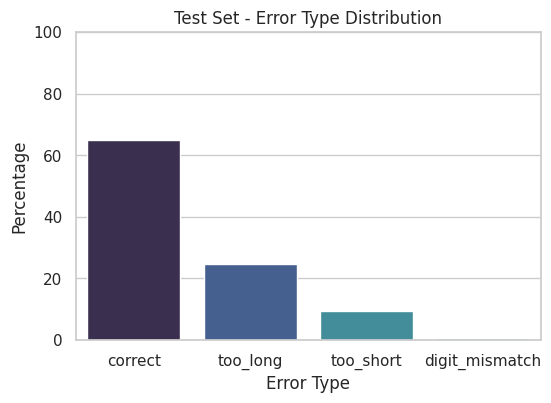

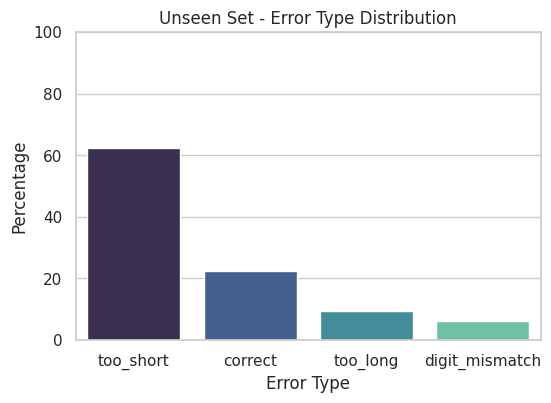

In [48]:
sns.set(style="whitegrid")

# Error type distribution
def plot_error_distribution(df, title):
    plt.figure(figsize=(6, 4))
    err_pct = df['err_type'].value_counts(normalize=True).mul(100).round(1)
    sns.barplot(x=err_pct.index, y=err_pct.values, palette='mako')
    plt.title(f"{title} - Error Type Distribution")
    plt.ylabel("Percentage")
    plt.xlabel("Error Type")
    plt.ylim(0, 100)
    plt.show()

plot_error_distribution(test_df, "Test Set")
plot_error_distribution(unseen_df, "Unseen Set")

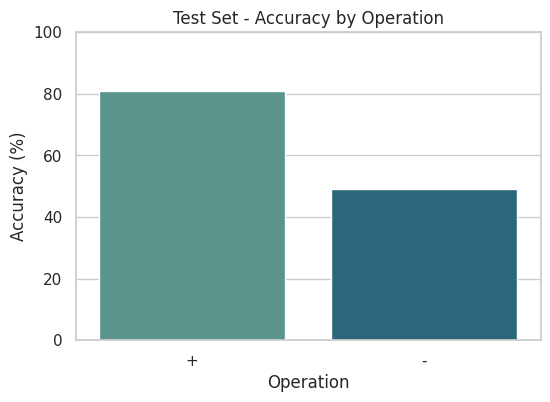

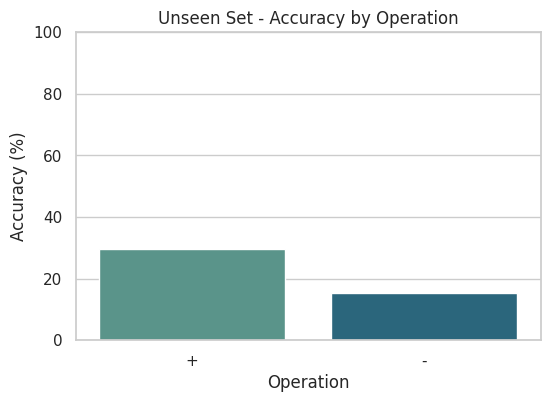

In [49]:
def plot_accuracy_by_operation(df, title):
    acc = df.groupby('op')['correct'].mean().mul(100).round(1).sort_index()
    plt.figure(figsize=(6, 4))
    sns.barplot(x=acc.index, y=acc.values, palette='crest')
    plt.title(f"{title} - Accuracy by Operation")
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Operation")
    plt.ylim(0, 100)
    plt.show()

plot_accuracy_by_operation(test_df, "Test Set")
plot_accuracy_by_operation(unseen_df, "Unseen Set")


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


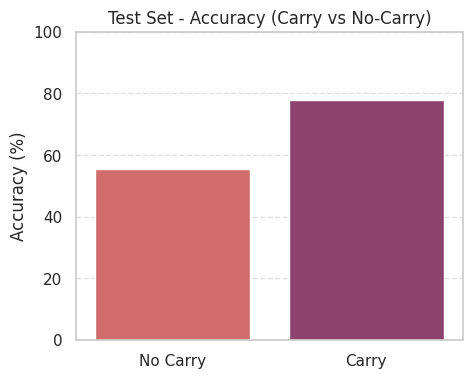

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


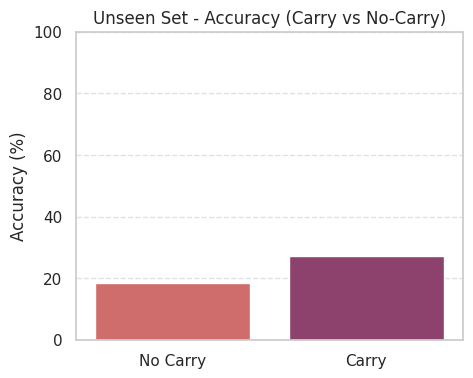

In [50]:
def plot_carry_accuracy(df, title):
    # Check if 'carry' and 'correct' columns exist and are non-empty
    if 'carry' not in df.columns or 'correct' not in df.columns:
        print(f"Missing necessary columns in {title} set.")
        return
    
    # Drop rows where 'carry' is missing or not 0/1
    df_clean = df[df['carry'].isin([0, 1])].copy()
    
    if df_clean.empty:
        print(f"No valid carry data to plot in {title} set.")
        return

    # Compute accuracy grouped by carry
    acc = df_clean.groupby('carry')['correct'].mean().mul(100).round(1)

    # Map 0/1 to readable labels (in the same order as acc index)
    labels = ['No Carry' if i == 0 else 'Carry' for i in acc.index]

    # Plotting
    plt.figure(figsize=(5, 4))
    sns.barplot(x=labels, y=acc.values, palette='flare')
    plt.title(f"{title} - Accuracy (Carry vs No-Carry)")
    plt.ylabel("Accuracy (%)")
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()

plot_carry_accuracy(test_df, "Test Set")
plot_carry_accuracy(unseen_df, "Unseen Set")


<Figure size 800x500 with 0 Axes>

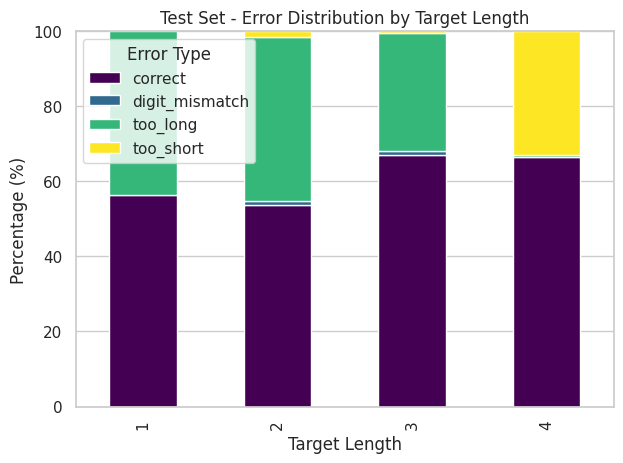

<Figure size 800x500 with 0 Axes>

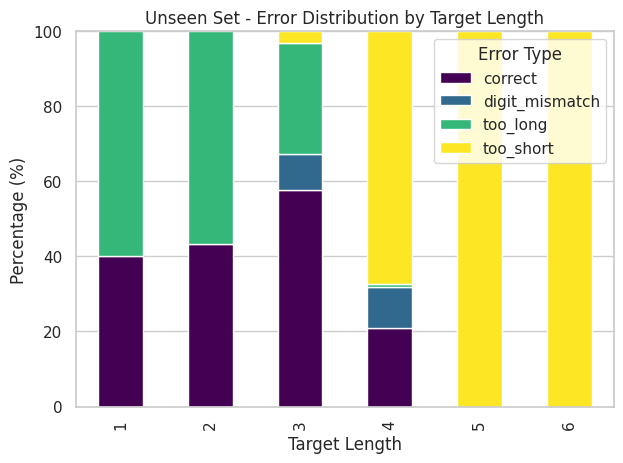

In [51]:
def plot_errors_by_target_length(df, title):
    crosstab = pd.crosstab(df['target_len'], df['err_type'], normalize='index').mul(100).round(1)
    plt.figure(figsize=(8, 5))
    crosstab.plot(kind='bar', stacked=True, colormap='viridis')
    plt.title(f"{title} - Error Distribution by Target Length")
    plt.ylabel("Percentage (%)")
    plt.xlabel("Target Length")
    plt.legend(title="Error Type")
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

plot_errors_by_target_length(test_df, "Test Set")
plot_errors_by_target_length(unseen_df, "Unseen Set")

## 5. Ablation Study

In [52]:
def ablation_study(model_cls, dataset_dict, device, ablation_variants, epochs=5, lr=1e-4, lambda_acc=0.5):
    """
    Runs training and evaluation for each variant in ablation_variants.
    Returns a DataFrame summarizing performance on test set.
    """
    results = []

    for name, params in ablation_variants.items():
        # Instantiate model with variant-specific hyperparameters
        model = model_cls(
            src_vocab_size=params['src_vocab_size'],
            tgt_vocab_size=params['tgt_vocab_size'],
            d_model=params['d_model'],
            num_layers=params['num_layers'],
            num_heads=params['num_heads'],
            d_ff=params['d_ff'],
            max_len=params['max_seq_len']
        ).to(device)

        # Optimizer and loss
        optimizer = optim.Adam(model.parameters(), lr=lr)
        ce_loss_fn = nn.CrossEntropyLoss(ignore_index=pad_token_id)

        print(f'Training {name} model...')
        train_full(
            model, train_loader, val_loader,
            optimizer, ce_loss_fn,
            pad_token_id, sos_token_id, eos_token_id,
            device, lambda_acc,
            EPOCHS=epochs, patience=3,
            path=f"/kaggle/working/best_model_{name}.pt"
        )

        # Final evaluation on test set
        metrics = evaluate(model, test_loader, ce_loss_fn, pad_token_id, sos_token_id, eos_token_id, device, lambda_acc)

        results.append({
            'Variant': name,
            'ExactMatch': metrics['exact_match'],
            'CharAccuracy': metrics['char_accuracy'],
            'Perplexity': metrics['perplexity']
        })

    return pd.DataFrame(results)

In [53]:
# Example usage:
ablation_variants = {
    "Fewer Heads": {
        'src_vocab_size': len(vocab_dict),
        'tgt_vocab_size': len(vocab_dict),
        'd_model': 256,
        'num_heads': 4,
        'num_layers': 3,
        'd_ff': 1024,
        'max_seq_len': 20
    },
    "Shallower Model": {
        'src_vocab_size': len(vocab_dict),
        'tgt_vocab_size': len(vocab_dict),
        'd_model': 256,
        'num_heads': 8,
        'num_layers': 1,
        'd_ff': 1024,
        'max_seq_len': 20
    }
}

dataset_dict = {'train': train_dataset, 'val': val_dataset, 'test': test_dataset}
ablation_df = ablation_study(Transformer, dataset_dict, device, ablation_variants, epochs=5, lr=1e-4, lambda_acc=lambda_acc)
ablation_df

Training Fewer Heads model...


KeyboardInterrupt: 